## From Scratch Implementation

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# %matplotlib inline
plt.rcParams.update({'font.size': 14})

import warnings
warnings.filterwarnings('ignore')

In [2]:
credit_data = pd.read_csv('Credit_N400_p9.csv')
print("shape: {}".format(credit_data.shape))

shape: (400, 10)


In [3]:
credit_data.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,903
2,104.593,7075,514,4,71,11,Male,No,No,580
3,148.924,9504,681,3,36,11,Female,No,No,964
4,55.882,4897,357,2,68,16,Male,No,Yes,331


In [4]:
all_features = credit_data.columns[:-1]
prediction_variable =  credit_data.columns[-1]
quantitative_features = all_features[0:6]
qualitative_features = all_features[6:]

In [5]:
# converting qualitative features into numerical values.
for feature in qualitative_features:
    credit_data[feature].replace(credit_data[feature].unique(), range(credit_data[feature].nunique()), inplace=True)

credit_data.describe()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000
mean,45.218885,4735.600000,354.940000,2.957500,55.667500,13.450000,0.517500,0.100000,0.38750,520.015000
std,35.244273,2308.198848,154.724143,1.371275,17.249807,3.125207,0.500319,0.300376,0.48779,459.758877
min,10.354000,855.000000,93.000000,1.000000,23.000000,5.000000,0.000000,0.000000,0.00000,0.000000
25%,21.007250,3088.000000,247.250000,2.000000,41.750000,11.000000,0.000000,0.000000,0.00000,68.750000
50%,33.115500,4622.500000,344.000000,3.000000,56.000000,14.000000,1.000000,0.000000,0.00000,459.500000
75%,57.470750,5872.750000,437.250000,4.000000,70.000000,16.000000,1.000000,0.000000,1.00000,863.000000
max,186.634000,13913.000000,982.000000,9.000000,98.000000,20.000000,1.000000,1.000000,1.00000,1999.000000


In [6]:
X = credit_data[all_features].to_numpy()
N, p = X.shape
Y = credit_data[prediction_variable].to_numpy().reshape(N, 1)

In [7]:
# utility methods

def error(X, Y, beta):
    return Y - np.matmul(X, beta)

def residual_sum_squares(X, Y, beta):
    e = error(X, Y, beta)
    return np.matmul(e.T, e)

def mean_squared_error(X, Y, beta):
    return residual_sum_squares(X, Y, beta) / len(X)

def standardize_data(data):
    rows, cols = data.shape
    for i in range(cols):
        data[:,i] = (data[:,i] - (data[:,i].mean())) / data[:,i].std()
    return data

def centralize_data(data):
    rows, cols = data.shape
    for i in range(cols):
        data[:,i] = (data[:,i] - (data[:,i].mean()))
    return data

def scale_folds(X_train, Y_train, X_val, Y_val):
    rows, cols = X_train.shape
    for i in range(cols):
        mean = X_train[:,i].mean()
        std = X_train[:,i].std()
        X_train[:,i] = (X_train[:,i] - mean) / std
        X_val[:,i] = (X_val[:,i] - mean) / std
        
    rows, cols = Y_train.shape
    for i in range(cols):
        mean = Y_train[:,i].mean()
        Y_train[:,i] = Y_train[:,i] - mean
        Y_val[:,i] = Y_val[:,i] - mean
        
    return X_train, Y_train, X_val, Y_val

def sign(arg):
    return -1 if arg < 0 else 1

def get_as_table(data):
    pTable = PrettyTable()
    pTable.clear()
    n = len(data)
    for i in range(n):
        pTable.add_row(data[i], divider=True)
    pTable.header = False
    return pTable

In [8]:
# Elastic Net
def elastic_net(X, Y, penalty, alpha, max_itr):
    N, p = X.shape
    beta = np.random.rand(p).reshape(p, 1)
    b = np.zeros(p)
    
    for k in range(p):
        b[k] = np.matmul(X[:, k].T, X[:, k])
    
    for i in range(max_itr):
        for k in range(p):
            e = error(X, Y, beta)
            a_k = np.matmul(X[:, k], (e + (X[:, k] * beta[k]).reshape(N, 1)))
            beta[k] = (sign(a_k) * max(0, (np.absolute(a_k) - ((penalty * (1 - alpha)) / 2)))) / (b[k] + penalty * alpha)
    
    return beta

# Elastic Net CV
def elastic_netCV(X, Y, k_folds, penalties, alphas, max_itr):
    N, p = X.shape
    batch_size = len(X) // k_folds
    n_penalties, n_alpha = len(penalties), len(alphas)
    beta_history = np.zeros((n_alpha, n_penalties, p))
    MSE = np.zeros((n_alpha, n_penalties))
    
    for alpha_idx in range(n_alpha):
        for penalty_idx in range(n_penalties):
            mse_s = []
            beta = 0
            start = 0
            for fold in range(k_folds):
                val_idx = range(start, start + batch_size)
                train_idx = [(i not in val_idx) for i in range(len(X))]
                
                X_train, Y_train, X_val, Y_val = scale_folds(X[train_idx], Y[train_idx], X[val_idx], Y[val_idx])
                
                beta = elastic_net(X_train, Y_train, penalties[penalty_idx], alphas[alpha_idx], max_itr)
                
                mse = mean_squared_error(X_val, Y_val, beta)
                mse_s.append(mse)
                
                start = start + batch_size
            MSE[alpha_idx, penalty_idx] = np.round(np.average(mse_s), 3)
            beta_history[alpha_idx, penalty_idx] = np.round(beta.T, 3)
            
    return beta_history, MSE

In [9]:
penalties = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
alphas = [0, 1/5, 2/5, 3/5, 4/5, 1]

In [10]:
beta_history_elastic, MSE_elastic = elastic_netCV(X, Y, 5, penalties, alphas, 1000)

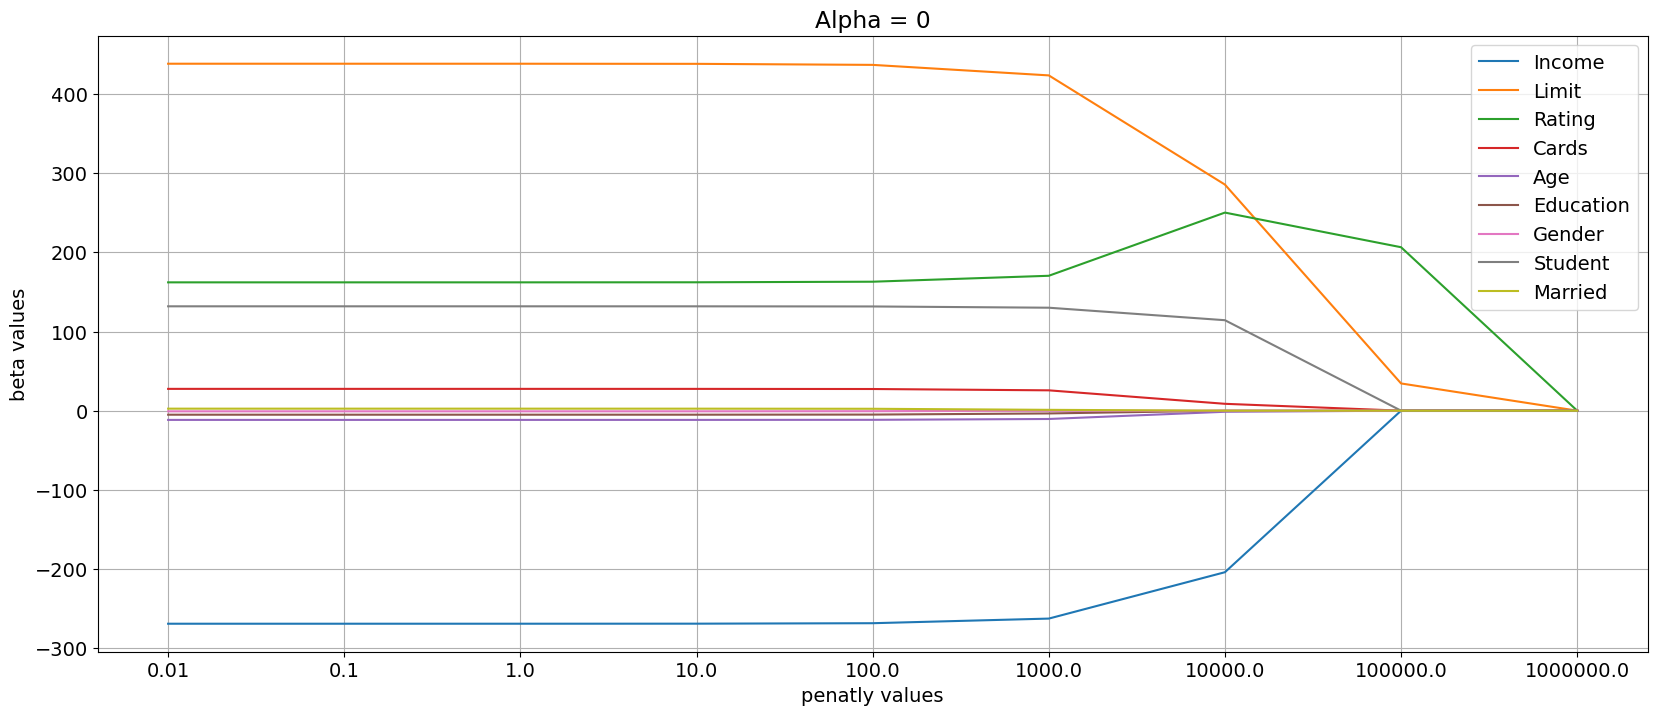

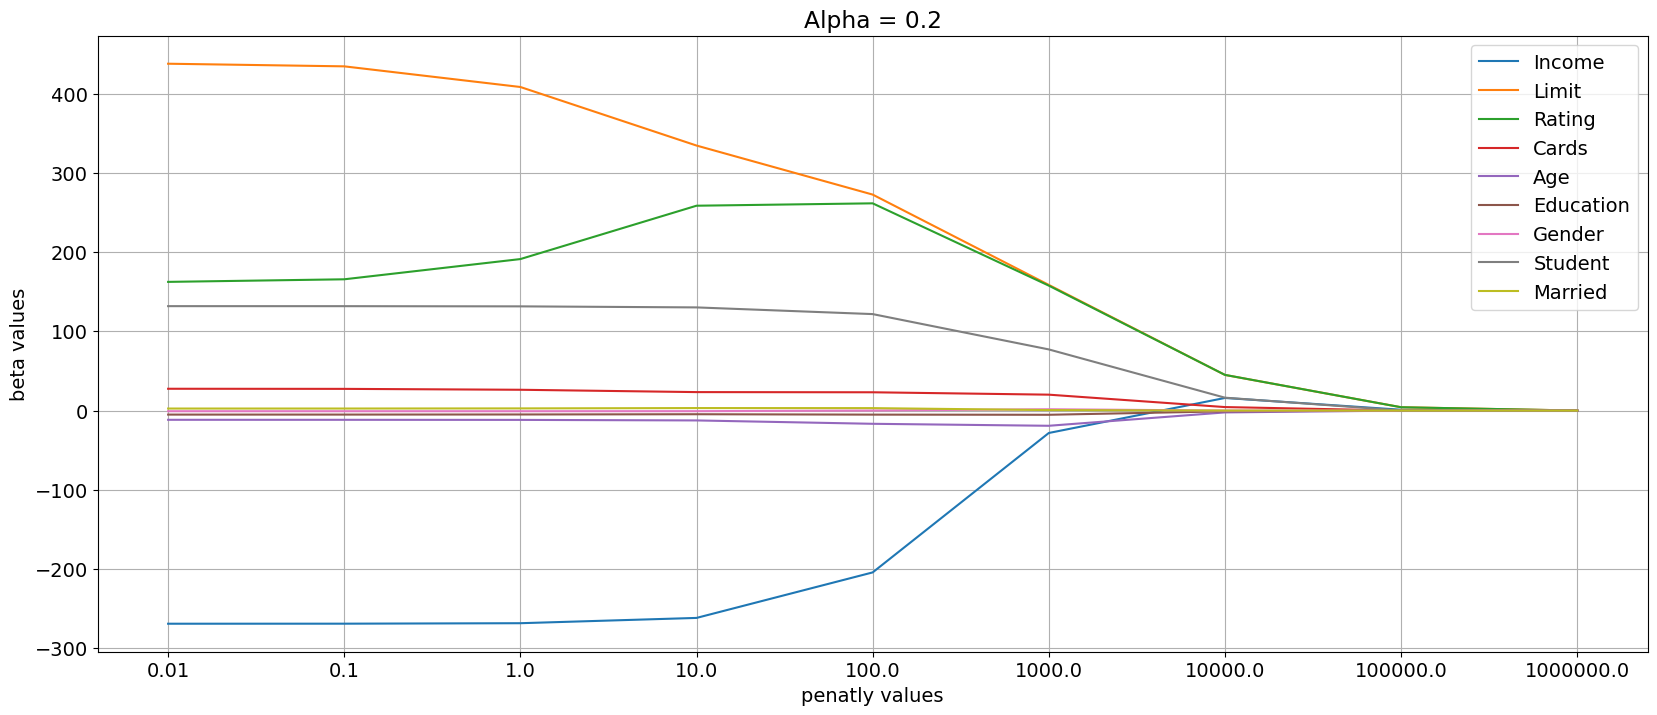

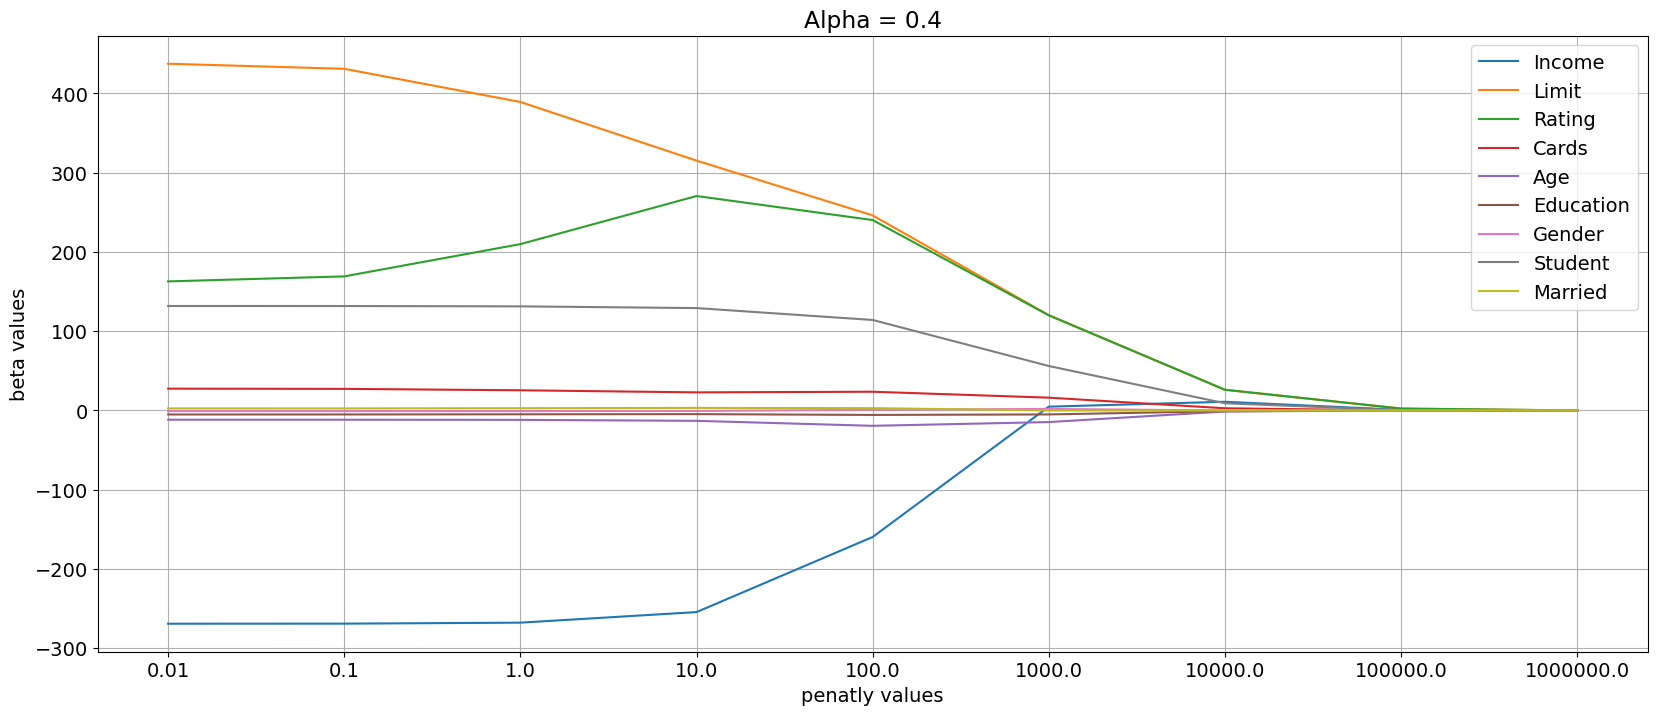

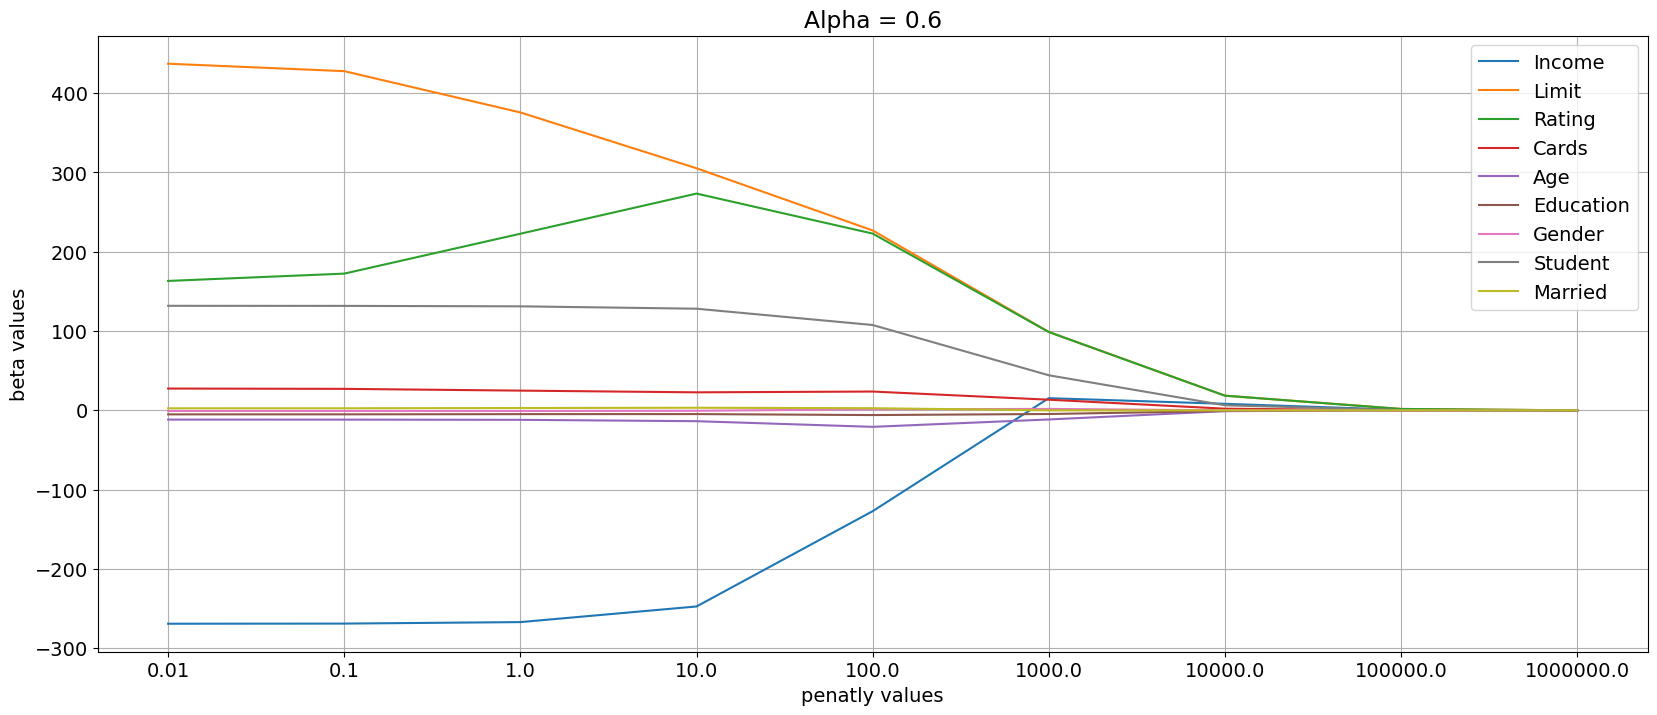

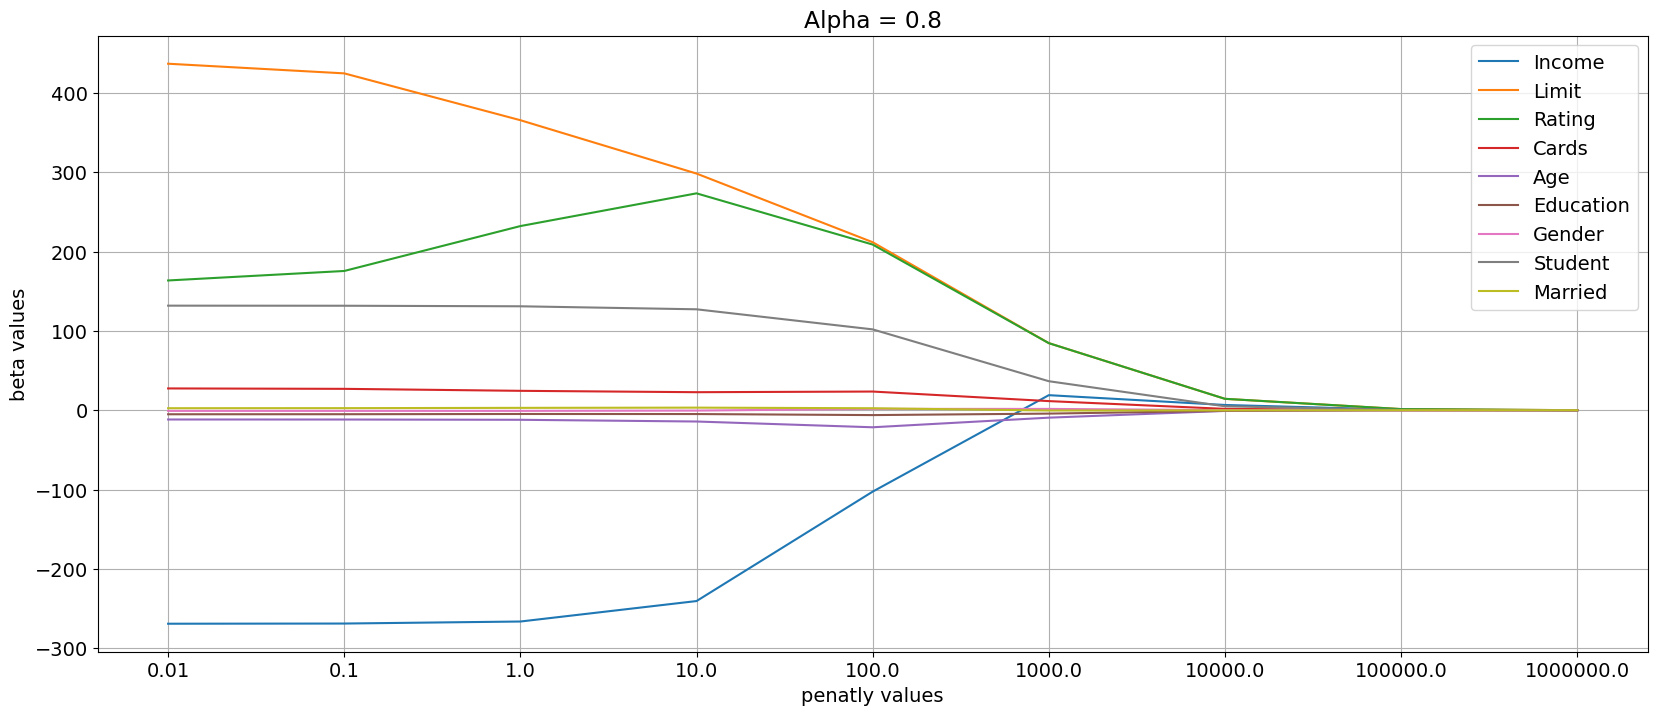

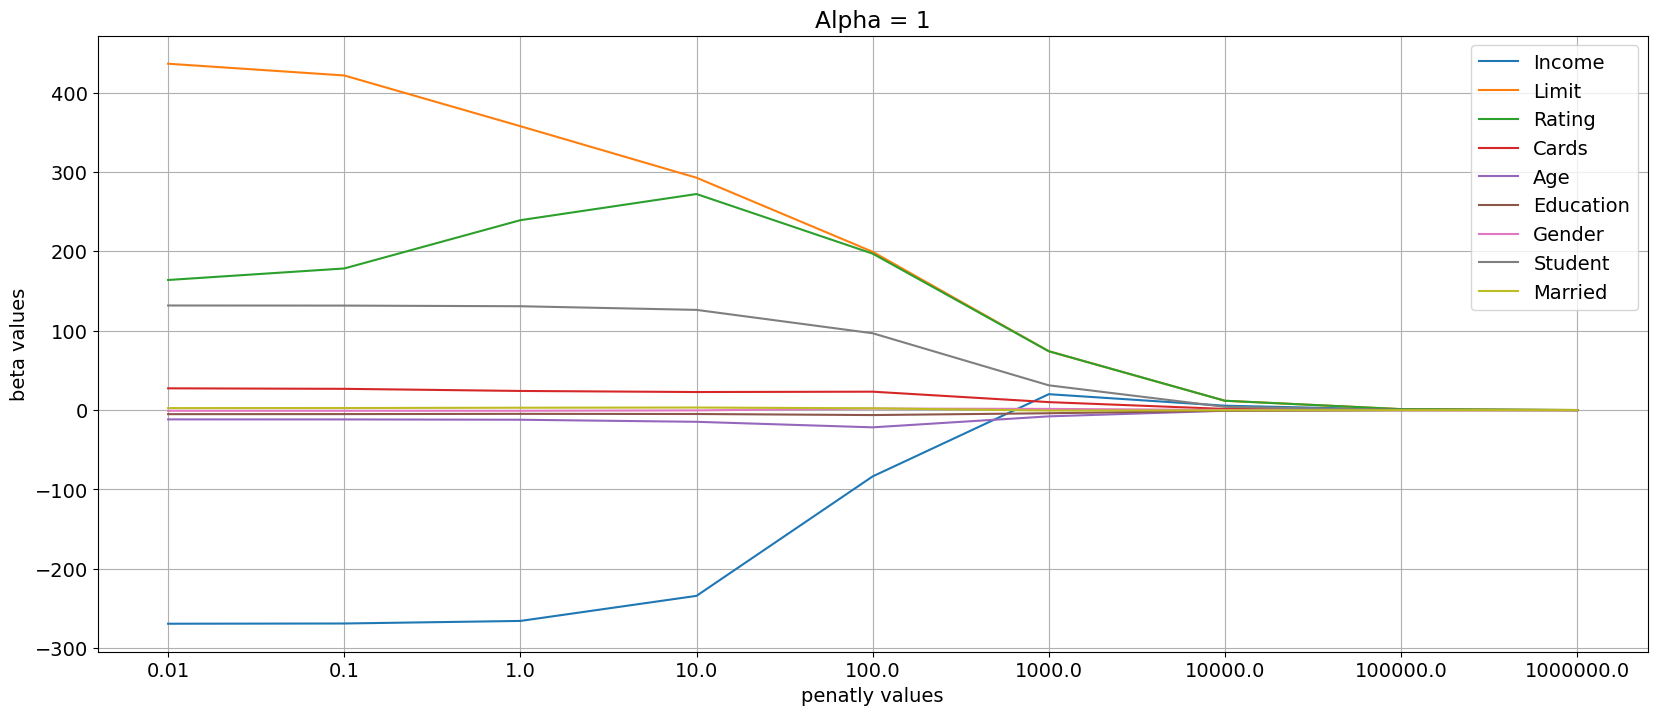

In [11]:
for alpha_idx in range(len(alphas)):
    plt.figure(figsize=(20,8))
    for i in range(p):
        plt.plot(beta_history_elastic[alpha_idx,:,i], label = all_features[i])
    plt.title(f'Alpha = {alphas[alpha_idx]}')
    plt.xlabel('penatly values')
    plt.ylabel('beta values')
    xlabels = [str(i) for i in penalties]
    plt.xticks(range(len(xlabels)), xlabels)
    plt.legend()
    plt.grid(True)
    plt.show()

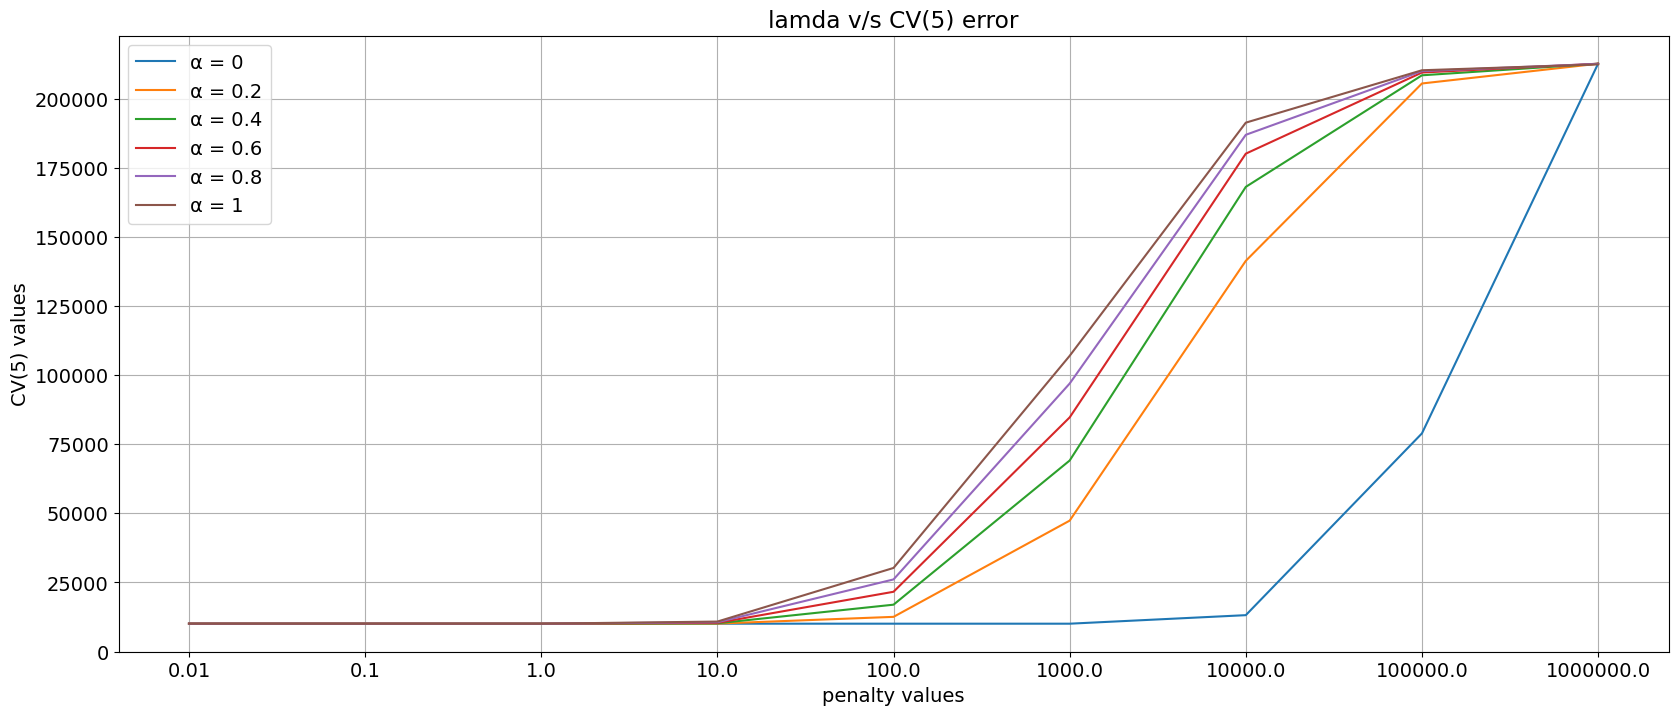

In [12]:
plt.figure(figsize=(20,8))
for i in range(len(alphas)):
    plt.plot(MSE_elastic[i,:], label = f'α = {alphas[i]}')
plt.title(f'lamda v/s CV(5) error')
plt.xlabel('penalty values')
plt.ylabel('CV(5) values')
xlabels = [str(i) for i in penalties]
plt.xticks(range(len(xlabels)), xlabels)
plt.legend()
plt.grid(True)
plt.show()

In [13]:
min_idx_elastic = np.unravel_index(np.argmin(MSE_elastic, axis=None), MSE_elastic.shape)
print("The pair of values of 𝛼 and 𝜆 that generated the smallest CV(5) error are,")
min_alpha_elatic, min_penalty_elastic = alphas[min_idx_elastic[0]], penalties[min_idx_elastic[1]]
print(f'𝛼 = {min_alpha_elatic}, 𝜆 = {min_penalty_elastic}')

The pair of values of 𝛼 and 𝜆 that generated the smallest CV(5) error are,
𝛼 = 0.4, 𝜆 = 1.0


In [14]:
X_scaled, Y_scaled = standardize_data(X), centralize_data(Y)

In [15]:
beta_elastic = np.round(elastic_net(X_scaled, Y_scaled, min_penalty_elastic, min_alpha_elatic, 1000), 3)

In [16]:
alpha_ridge = [1]
beta_history_ridge, MSE_ridge = elastic_netCV(X, Y, 5, penalties, alpha_ridge, 1000)

min_idx_ridge = np.unravel_index(np.argmin(MSE_ridge, axis=None), MSE_ridge.shape)
print("The value of 𝜆 that generated the smallest CV(5) error is,")
min_penalty_ridge =  penalties[min_idx_ridge[1]]
print(f'𝜆 = {min_penalty_ridge}')

beta_ridge = np.round(elastic_net(X_scaled, Y_scaled, min_penalty_ridge, 1, 1000), 3)

The value of 𝜆 that generated the smallest CV(5) error is,
𝜆 = 0.1


In [17]:
alpha_lasso = [0]
beta_history_lasso, MSE_lasso = elastic_netCV(X, Y, 5, penalties, alpha_lasso, 1000)

min_idx_lasso = np.unravel_index(np.argmin(MSE_lasso, axis=None), MSE_lasso.shape)
print("The value of 𝜆 that generated the smallest CV(5) error is,")
min_penalty_lasso =  penalties[min_idx_lasso[1]]
print(f'𝜆 = {min_penalty_lasso}')

beta_lasso = np.round(elastic_net(X_scaled, Y_scaled, min_penalty_lasso, 0, 1000), 3)

The value of 𝜆 that generated the smallest CV(5) error is,
𝜆 = 1000.0


In [18]:
three_beta = np.vstack((all_features, beta_ridge.T, beta_elastic.T, beta_lasso.T))
three_beta = np.hstack(([['Model'], ['Ridge'], ['Elastic'], ['Lasso']], three_beta))
print(get_as_table(three_beta))

+---------+----------+---------+---------+--------+---------+-----------+--------+---------+---------+
|  Model  |  Income  |  Limit  |  Rating | Cards  |   Age   | Education | Gender | Student | Married |
+---------+----------+---------+---------+--------+---------+-----------+--------+---------+---------+
|  Ridge  | -274.001 | 431.552 |  182.98 | 23.988 | -10.957 |   -3.401  | -5.188 | 127.726 |  3.509  |
+---------+----------+---------+---------+--------+---------+-----------+--------+---------+---------+
| Elastic | -272.986 | 400.655 | 212.901 | 22.716 | -11.067 |   -3.227  | -5.155 | 127.417 |  3.731  |
+---------+----------+---------+---------+--------+---------+-----------+--------+---------+---------+
|  Lasso  | -268.516 | 432.207 | 176.708 |  23.2  | -10.025 |   -2.165  | -3.782 |  126.32 |  2.371  |
+---------+----------+---------+---------+--------+---------+-----------+--------+---------+---------+


The Model Parameters obtained from ElasticNet, Ridge Regression and LASSO are comparable.

The Model has 40% Ridge characteristics, and 60% Lasso characteristics.

The features "Income", "Limit", "Rating" and "Student" are strongly connected to the response variable "Balance".

The features "Cards" and "Age" has an intermediate level of influence over "Balance".

And finally, the features "Education", "Gender" and "Married" affect the response variable the least.

## Library Implementation

_Note: For the Sci-Kit Learn Library, the parameter "alpha" is actually the PENALTY TERM and not the trade-off between Ridge and Lasso nature. The Trade-off is adjusted by the parameter "l1-ratio", which is the measure of Lasso nature of the model._

_So Effectively,_

_Library "alpha" = penalties_

_Library "l1-ratio" = 1 - alpha_

In [19]:
import warnings
warnings.filterwarnings('ignore') 

from sklearn.metrics import mean_squared_error as skl_MSE
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score

In [20]:
def elastic_netCV_v2(X, Y, k_folds, penalties, alphas, max_itr):
    n_penalties, n_alpha = len(penalties), len(alphas)
    beta_history = np.zeros((n_alpha, n_penalties, p))
    MSE = np.zeros((n_alpha, n_penalties))
    
    for alpha_idx in range(n_alpha):
        for penalty_idx in range(n_penalties):
            beta = 0
            start = 0
            eNet = ElasticNet(alpha=penalties[penalty_idx], l1_ratio=alphas[alpha_idx])
            mse_s = -cross_val_score(eNet, X, Y, cv=k_folds, scoring='neg_mean_squared_error')
            beta = eNet.fit(X, Y).coef_
            MSE[alpha_idx, penalty_idx] = np.round(np.average(mse_s), 3)
            beta_history[alpha_idx, penalty_idx] = np.round(beta.T, 3)
            
    return  beta_history, MSE

In [21]:
alphas_adj = [np.round(1 - alpha, 1) for alpha in alphas]
beta_history_elasatic_skl, MSE_elastic_skl = elastic_netCV_v2(X, Y, 5, penalties, alphas_adj, 1000)

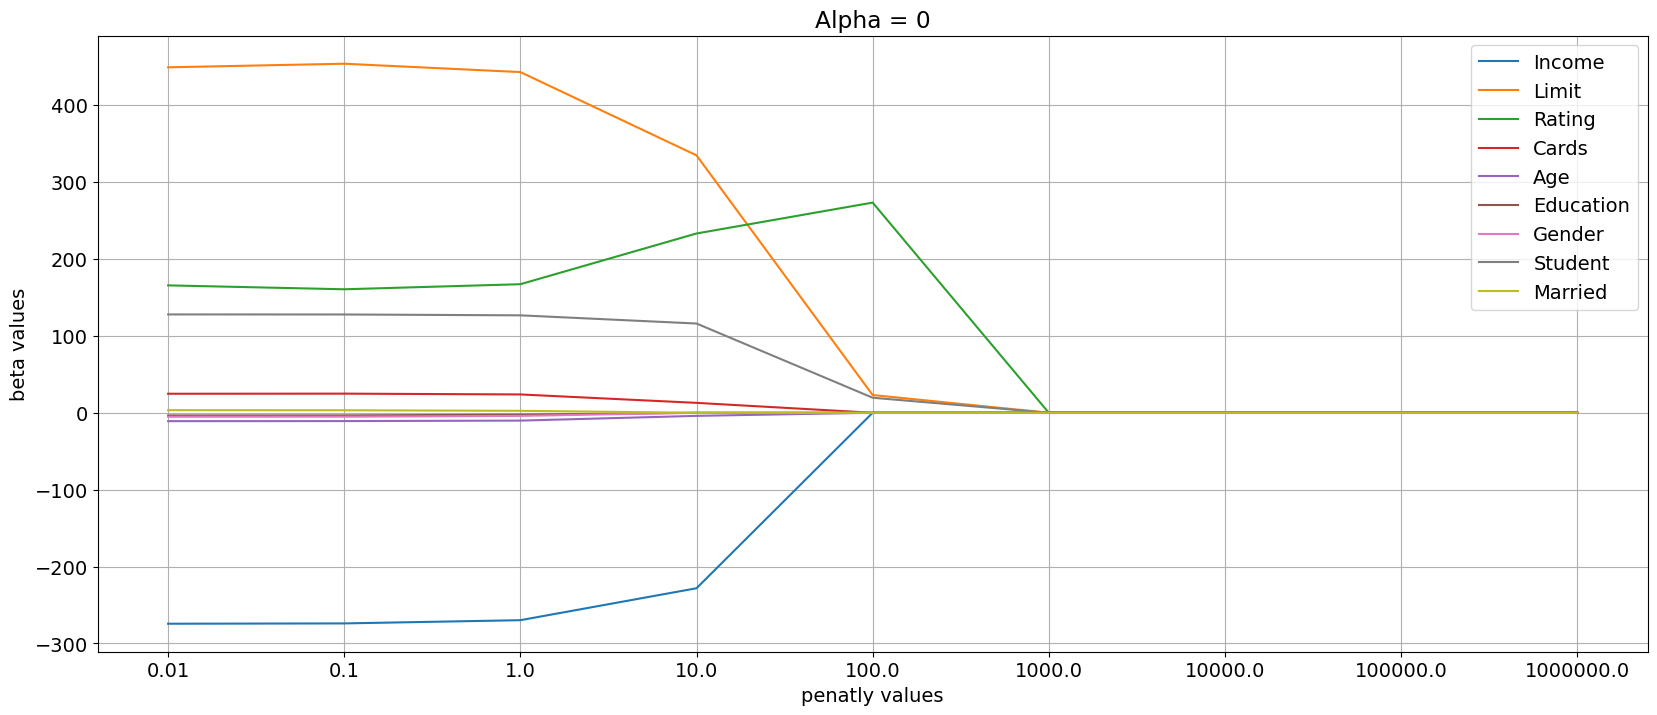

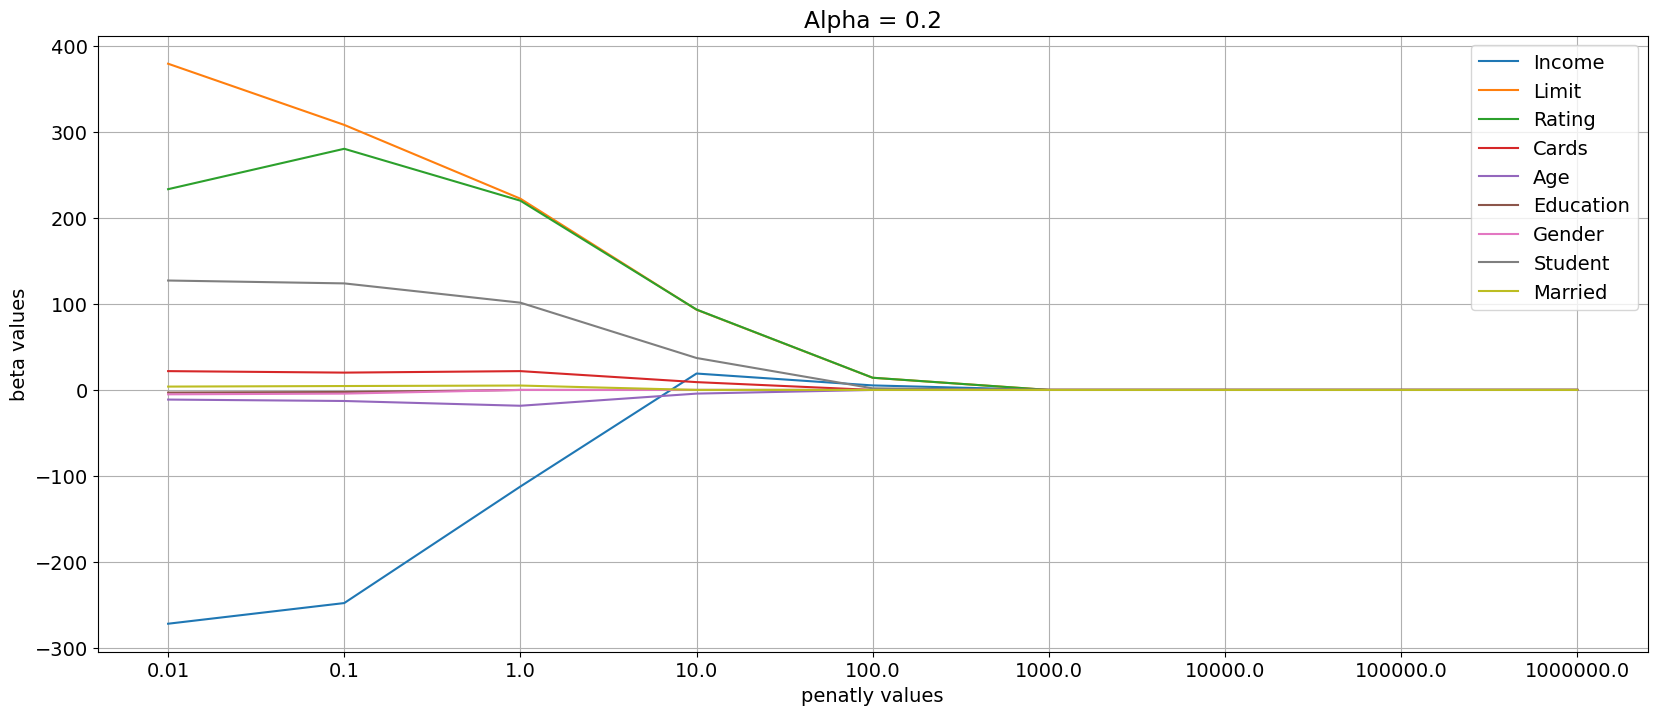

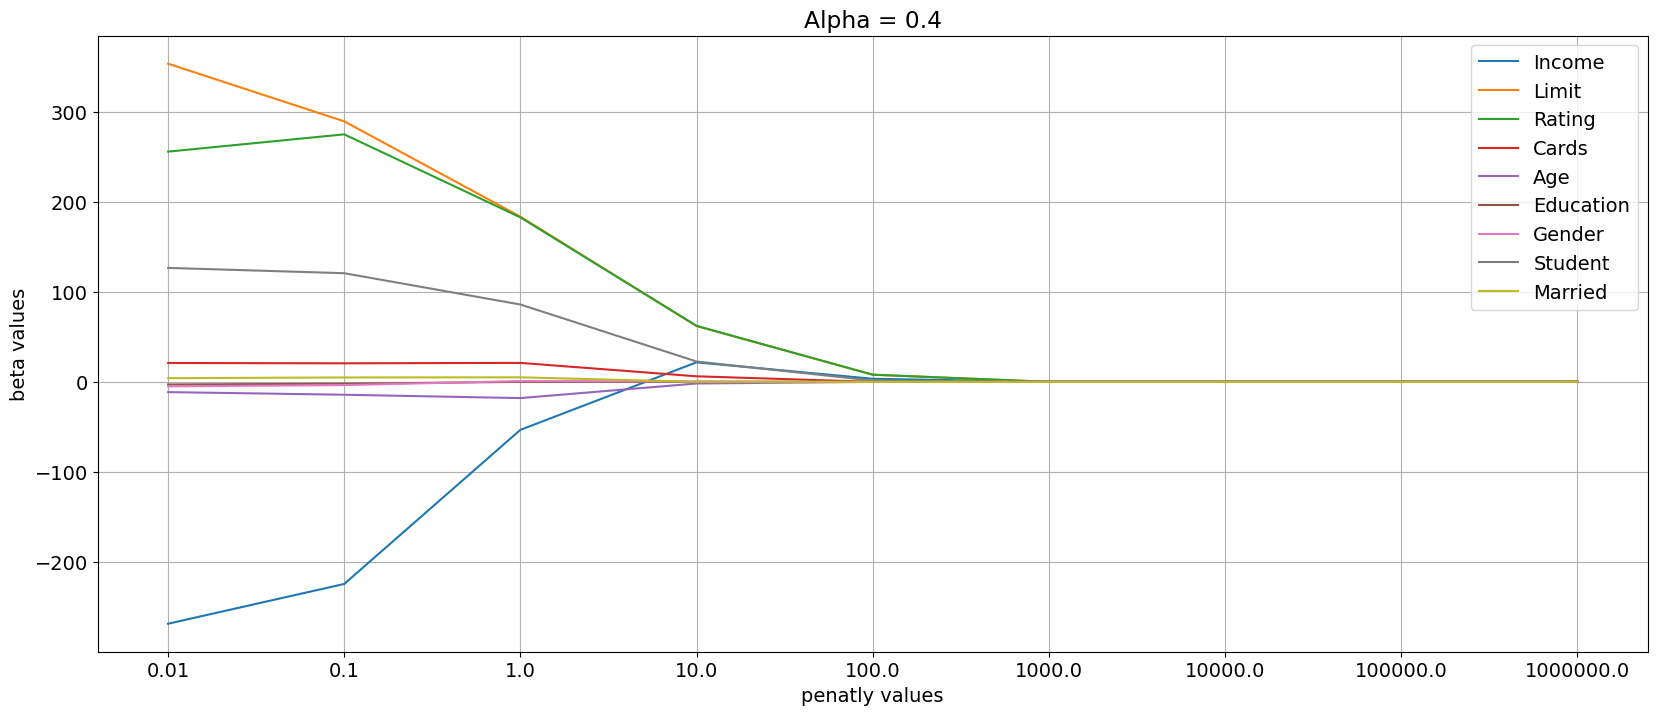

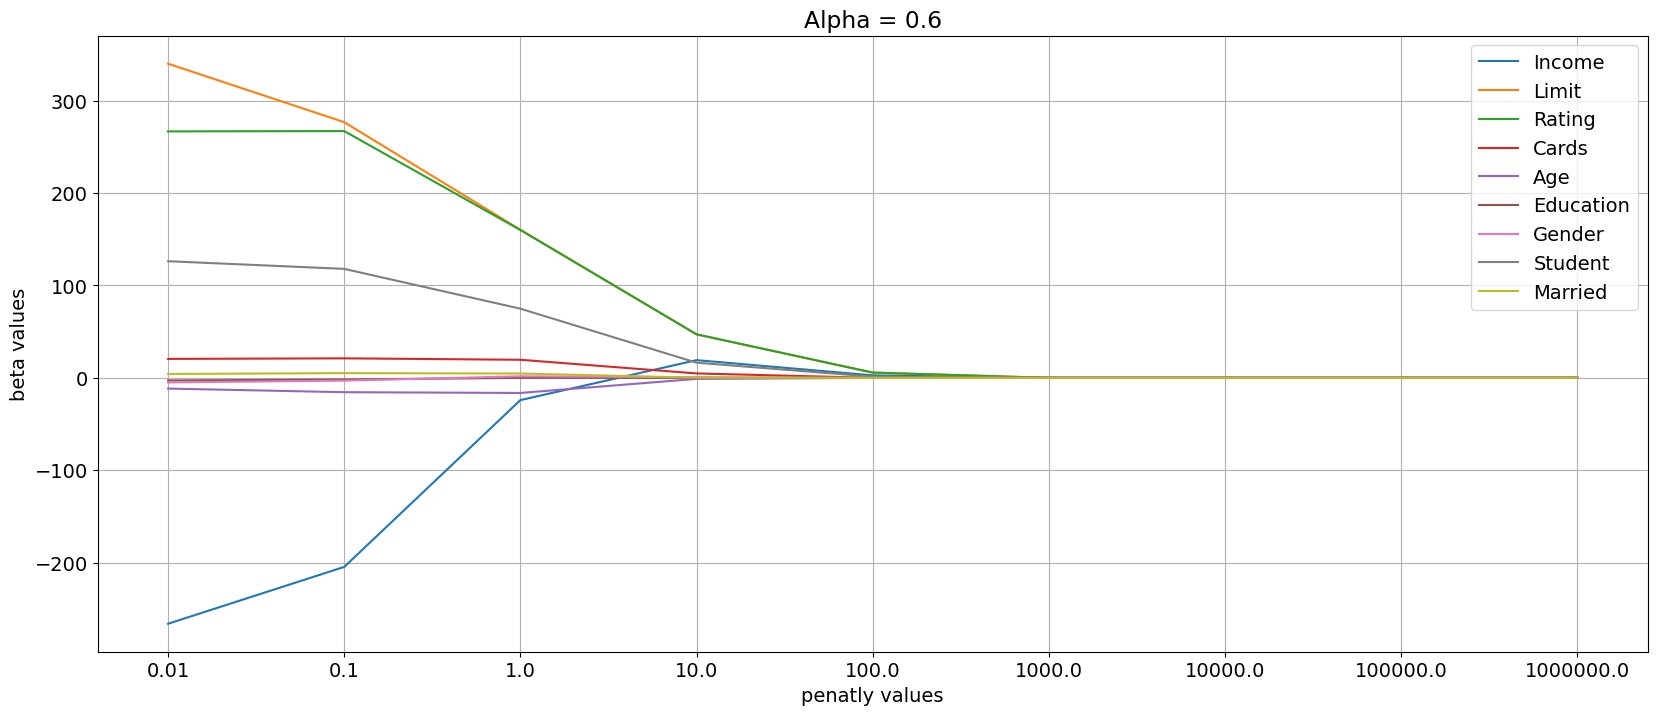

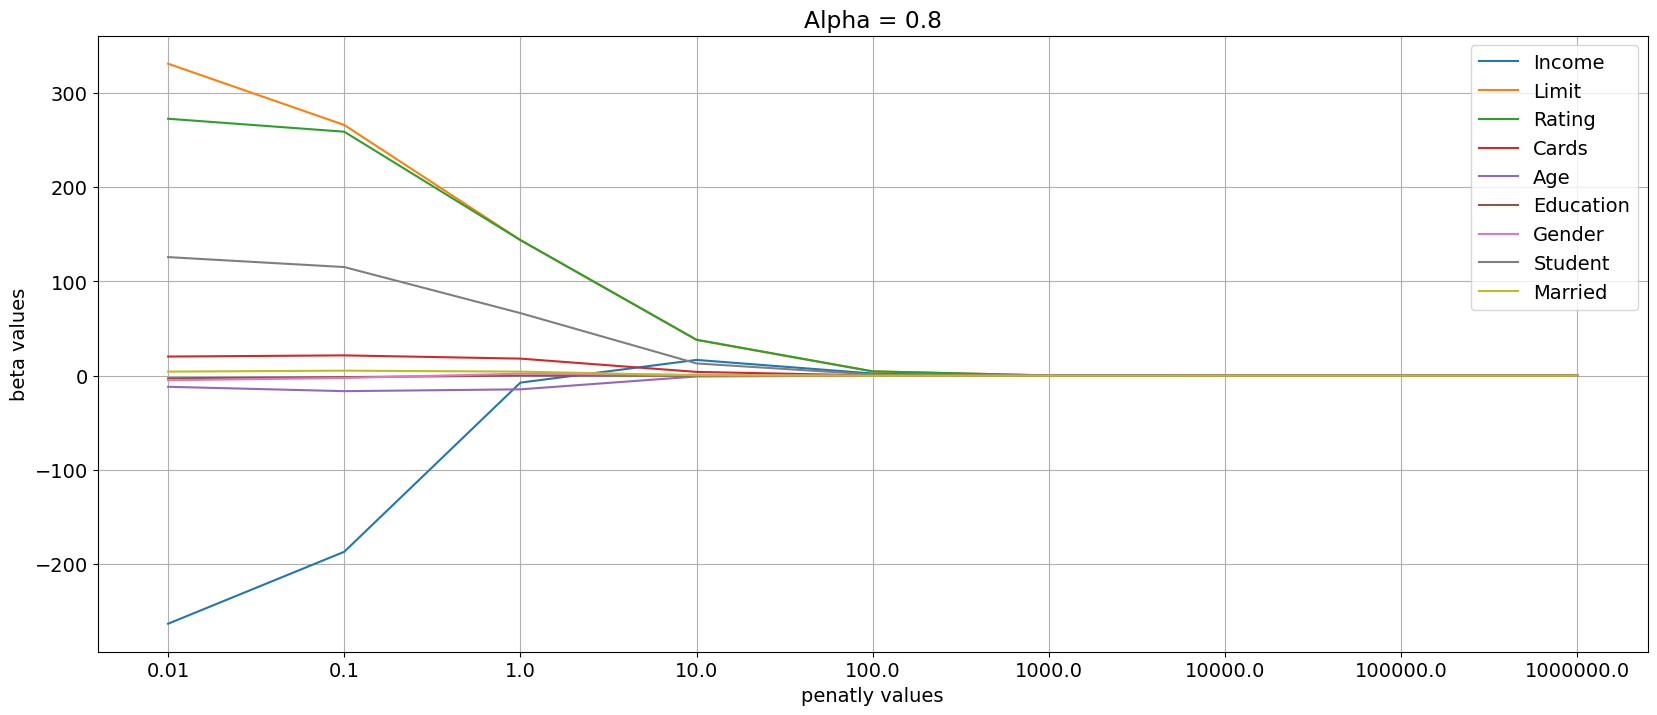

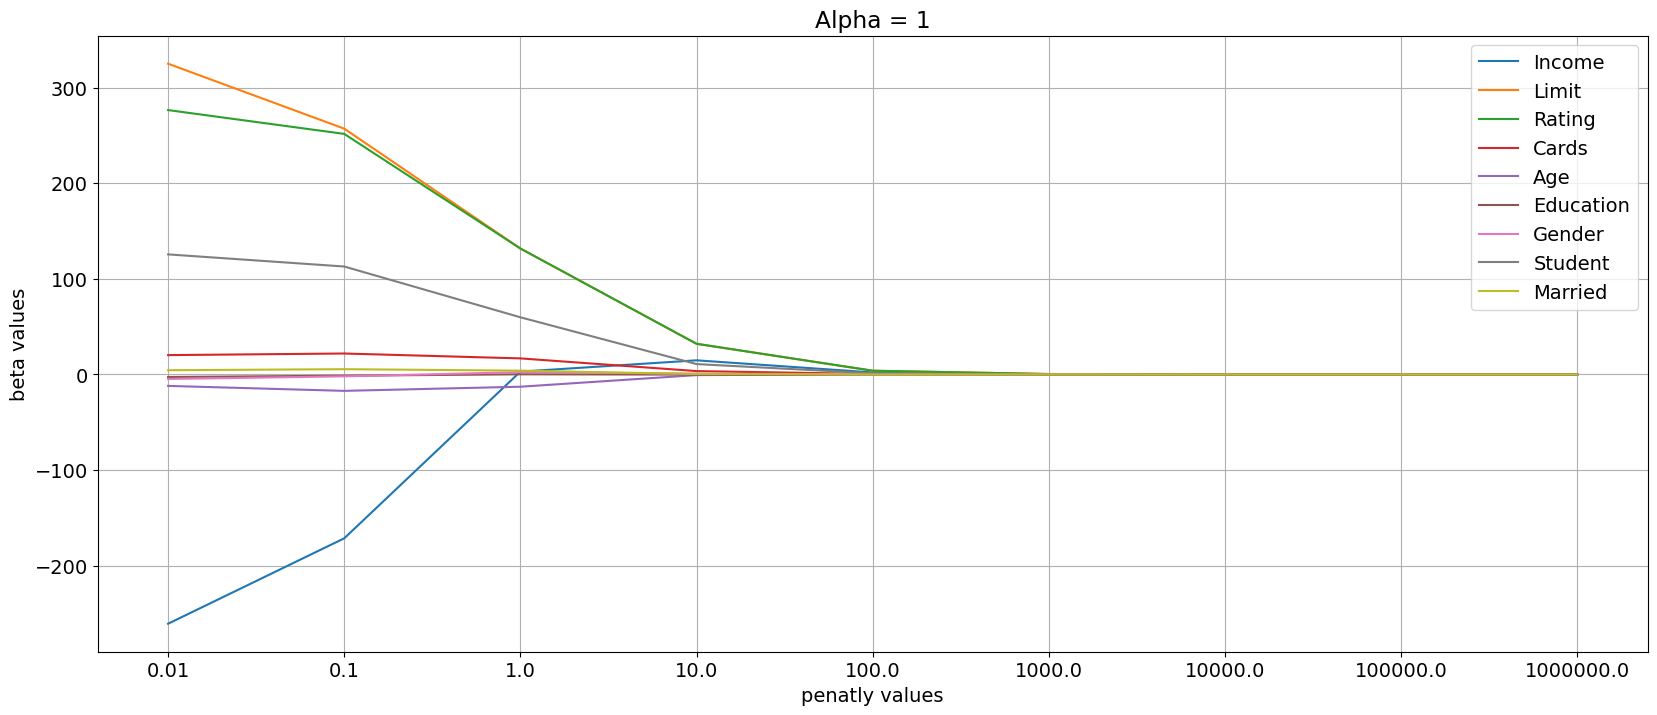

In [22]:
for alpha_idx in range(len(alphas)):
    plt.figure(figsize=(20,8))
    for i in range(p):
        plt.plot(beta_history_elasatic_skl[alpha_idx,:,i], label = all_features[i])
    plt.title(f'Alpha = {alphas[alpha_idx]}')
    plt.xlabel('penatly values')
    plt.ylabel('beta values')
    xlabels = [str(i) for i in penalties]
    plt.xticks(range(len(xlabels)), xlabels)
    plt.legend()
    plt.grid(True)
    plt.show()

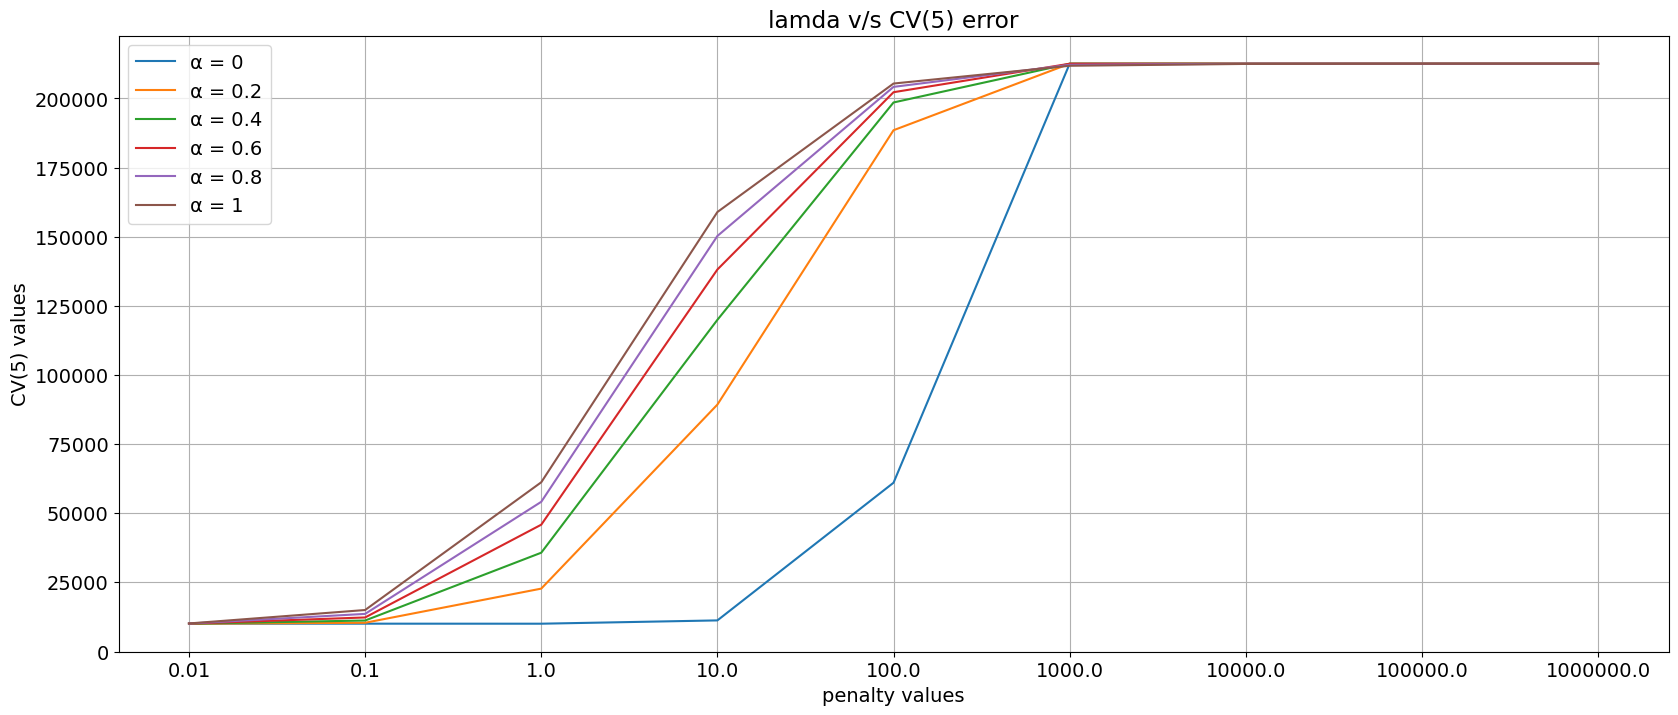

In [23]:
plt.figure(figsize=(20,8))
for i in range(len(alphas)):
    plt.plot(MSE_elastic_skl[i,:], label = f'α = {alphas[i]}')
plt.title(f'lamda v/s CV(5) error')
plt.xlabel('penalty values')
plt.ylabel('CV(5) values')
xlabels = [str(i) for i in penalties]
plt.xticks(range(len(xlabels)), xlabels)
plt.legend()
plt.grid(True)
plt.show()

In [24]:
min_idx_elastic_skl = np.unravel_index(np.argmin(MSE_elastic_skl, axis=None), MSE_elastic_skl.shape)
print("The pair of values of 𝛼 and 𝜆 that generated the smallest CV(5) error are,")
min_alpha_elatic_skl, min_penalty_elastic_skl = alphas[min_idx_elastic_skl[0]], penalties[min_idx_elastic_skl[1]]
print(f'𝛼 = {min_alpha_elatic_skl}, 𝜆 = {min_penalty_elastic_skl}')

The pair of values of 𝛼 and 𝜆 that generated the smallest CV(5) error are,
𝛼 = 0.2, 𝜆 = 0.01


In [25]:
eNet_skl = ElasticNet(alpha=min_penalty_elastic_skl, l1_ratio=min_alpha_elatic_skl).fit(X_scaled, Y_scaled)
beta_elastic_skl = np.round(eNet_skl.coef_, 3)

In [26]:
alpha_ridge = [0]

beta_history_ridge_skl, MSE_ridge_skl = elastic_netCV_v2(X, Y, 5, penalties, alpha_ridge, 1000)

min_idx_ridge_skl = np.unravel_index(np.argmin(MSE_ridge_skl, axis=None), MSE_ridge_skl.shape)
print("The value of 𝜆 that generated the smallest CV(5) error is,")
min_penalty_ridge_skl =  penalties[min_idx_ridge_skl[1]]
print(f'𝜆 = {min_penalty_ridge_skl}')

eNet_ridge_skl = ElasticNet(alpha=min_penalty_ridge_skl, l1_ratio=alpha_ridge[0]).fit(X_scaled, Y_scaled)

beta_ridge_skl = np.round(eNet_ridge_skl.coef_, 3)

The value of 𝜆 that generated the smallest CV(5) error is,
𝜆 = 0.01


In [27]:
alpha_lasso = [1]

beta_history_lasso_skl, MSE_lasso_skl = elastic_netCV_v2(X, Y, 5, penalties, alpha_lasso, 1000)

min_idx_lasso_skl = np.unravel_index(np.argmin(MSE_lasso_skl, axis=None), MSE_lasso_skl.shape)
print("The value of 𝜆 that generated the smallest CV(5) error is,")
min_penalty_lasso_skl =  penalties[min_idx_lasso_skl[1]]
print(f'𝜆 = {min_penalty_lasso_skl}')

eNet_lasso_skl = ElasticNet(alpha=min_penalty_lasso_skl, l1_ratio=alpha_lasso[0]).fit(X_scaled, Y_scaled)

beta_lasso_skl = np.round(eNet_lasso_skl.coef_, 3)

The value of 𝜆 that generated the smallest CV(5) error is,
𝜆 = 1.0


In [28]:
three_beta_skl = np.vstack((all_features, beta_ridge_skl.T, beta_elastic_skl.T, beta_lasso_skl.T))
three_beta_skl = np.hstack(([['Model'], ['Ridge'], ['Elastic'], ['Lasso']], three_beta_skl))
print(get_as_table(three_beta_skl))

+---------+----------+---------+---------+--------+---------+-----------+--------+---------+---------+
|  Model  |  Income  |  Limit  |  Rating | Cards  |   Age   | Education | Gender | Student | Married |
+---------+----------+---------+---------+--------+---------+-----------+--------+---------+---------+
|  Ridge  | -260.726 | 324.907 | 276.426 | 20.176 | -12.018 |   -2.69   | -4.773 | 125.518 |  4.375  |
+---------+----------+---------+---------+--------+---------+-----------+--------+---------+---------+
| Elastic | -263.396 | 331.218 | 272.798 | 20.289 | -11.824 |   -2.752  | -4.854 | 125.871 |  4.304  |
+---------+----------+---------+---------+--------+---------+-----------+--------+---------+---------+
|  Lasso  | -269.698 |  442.97 | 167.148 | 23.821 | -10.192 |   -2.469  | -4.066 | 126.676 |  2.523  |
+---------+----------+---------+---------+--------+---------+-----------+--------+---------+---------+


The model parameters of both manually implemented and library implemented Elastic Net are nearly same.

The Model Parameters of both implementations vary minimally. This variation can be associated to,
 - Different sampling technique employed.
 - Optimization algorithm used in SciKit Learn library.
 - Lesser iterations used in manual implementation.
 
By comparing the results, we can say that Manually Implemented Algorithm performed decently good.